<a href="https://colab.research.google.com/github/godinezseba/Tarea-2-RedesNeuronales/blob/master/notebooks/Parte%202/pruebas/GRU%2Bnode2vec_(por_grafo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/yekenot/pooled-gru-fasttext

In [ ]:
!git clone https://github.com/godinezseba/Tarea-2-RedesNeuronales

fatal: destination path 'Tarea-2-RedesNeuronales' already exists and is not an empty directory.


In [ ]:
!pip install tweet-preprocessor
%pip install scanf==1.5.2
%pip install node2vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.metrics import  classification_report
import re

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Cargar datos

In [ ]:
train = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

In [ ]:
labels = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_labels.csv' )

In [ ]:
test = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/test_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

# Grafos

In [ ]:
import os.path
from scanf import scanf
import networkx as nx
from node2vec import Node2Vec

import matplotlib.pyplot as plt
%matplotlib inline

## Creación de grafos

In [ ]:
def createGraph(DIR, fileGraph, labels):
  format = "['%s', '%s', '%f']->['%s', '%s', '%f']"

  listGraph = list()
  list_len_edges = list()

  for file in labels:
    fileName = f'{DIR}/{file}.txt'
    count_edges = 0
    tempGraph = nx.Graph()
    with open(fileName, 'r') as f:
      for line in f:
        parentId, parentTweet, parentTime, childId, childTweet, childTime = scanf(format, line.strip())
        # add edge to the list
        tempGraph.add_edge(parentTweet, childTweet)
        count_edges += 1
        tempGraph.add_node(parentTweet, time=[parentTime])
        tempGraph.add_node(childTweet, time=[childTime])
    list_len_edges.append(count_edges)
    listGraph.append(tempGraph)

  return listGraph, list_len_edges

In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/train'
fileGraph = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph.gpicke'

# add new graph
x_graph, list_len_edges = createGraph(DIR, fileGraph, labels['id'])

## Embedding

In [ ]:
vectorDimension = 256
fileNode = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/'
def graphEmbedding(graphList, n):
  print(f'Iteración: {n}')
  nodes = Node2Vec(graphList[n], 
                   dimensions=vectorDimension, 
                   walk_length=100, 
                   num_walks=1, 
                   workers=4, 
                   temp_folder=fileNode, 
                   weight_key='time'
                  )
  model = nodes.fit(window=10, min_count=1)
  return model.wv['ROOT']

In [ ]:
x_graph = np.array([graphEmbedding(x_graph, n) for n in range(len(x_graph))])

Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3817.34it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 0



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1615.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1
Iteración: 2





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5680.77it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1666.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]

Iteración: 3
Iteración: 4



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

Iteración: 5



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3925.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]

Iteración: 6



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

Iteración: 7



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Iteración: 8


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

Iteración: 9



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4898.15it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 10


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4737.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

Iteración: 11



Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 3285.59it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 12


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4820.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 13
Iteración: 14



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

Iteración: 15



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4804.93it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Iteración: 16
Iteración: 17


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 4800.11it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 18


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6341.13it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5130.25it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 19
Iteración: 20



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7767.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 101/101 [00:00<00:00, 2582.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 21
Iteración: 22



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 23


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]



Iteración: 24


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 5397.15it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

Iteración: 25



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6092.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 2808.15it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 26
Iteración: 27



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 28


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 3453.91it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

Iteración: 29



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities:  31%|███       | 109/357 [00:00<00:00, 1081.30it/s]

Iteración: 30
Iteración: 31


Computing transition probabilities: 100%|██████████| 357/357 [00:00<00:00, 1223.45it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5855.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4929.43it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 32
Iteración: 33



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1638.72it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 7236.10it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Iteración: 34
Iteración: 35


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6260.16it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 7455.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 36
Iteración: 37



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6553.60it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

Iteración: 38
Iteración: 39



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 40


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6446.40it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]

Iteración: 41



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 42
Iteración: 43



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2548.95it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 4242.21it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 44
Iteración: 45



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6677.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

Iteración: 46



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

Iteración: 47



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 48



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

Iteración: 49



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3566.27it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

Iteración: 50



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 51



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 4048.41it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 52
Iteración: 53


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6187.81it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 91/91 [00:00<00:00, 2719.21it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 54
Iteración: 55


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 4085.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 56


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Iteración: 57


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

Iteración: 58



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4846.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 59
Iteración: 60



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5711.07it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5658.22it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 61
Iteración: 62



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 965.76it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5470.49it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]

Iteración: 63
Iteración: 64



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 4195.52it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 65


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 7052.21it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3128.91it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 66
Iteración: 67



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3218.14it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

Iteración: 68



Computing transition probabilities: 100%|██████████| 57/57 [00:00<00:00, 5308.77it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 69


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 5871.63it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4956.83it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 70
Iteración: 71


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3600.70it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

Iteración: 72



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

Iteración: 73



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3266.23it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 74


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 75


Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3585.84it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 76


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 6975.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 3999.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 77
Iteración: 78



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 3620.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 4049.53it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 79
Iteración: 80



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 2435.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 81


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3841.16it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


Iteración: 82


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

Iteración: 83



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

Iteración: 84



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6461.22it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

Iteración: 85



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5434.36it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2353.71it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 29.05it/s]

Iteración: 86
Iteración: 87



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 88


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 8610.01it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3098.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 89
Iteración: 90



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 91



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 99/99 [00:00<00:00, 2349.48it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 92



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 7024.85it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2945.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]

Iteración: 93
Iteración: 94



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:  96%|█████████▌| 194/203 [00:00<00:00, 1938.54it/s]

Iteración: 95
Iteración: 96


Computing transition probabilities: 100%|██████████| 203/203 [00:00<00:00, 1804.89it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2813.84it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 5936.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 97
Iteración: 98



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5370.02it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Iteración: 99


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2674.65it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6084.58it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 100
Iteración: 101



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6185.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Iteración: 102


Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 4761.13it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 103


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 3651.43it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 104
Iteración: 105



Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 3777.26it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 106


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5749.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

Iteración: 107



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3579.16it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

Iteración: 108



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5351.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

Iteración: 109



Computing transition probabilities: 100%|██████████| 87/87 [00:00<00:00, 3557.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 110


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6084.09it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


Iteración: 111


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3925.27it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

Iteración: 112



Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 3126.22it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 113


Computing transition probabilities: 100%|██████████| 127/127 [00:00<00:00, 2245.60it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 114



Computing transition probabilities: 100%|██████████| 177/177 [00:00<00:00, 1616.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 115


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3336.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 116
Iteración: 117



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2358.45it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

Iteración: 118



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 2498.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 119


Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3479.79it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 120


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3297.24it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

Iteración: 121



Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3538.40it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 122


Computing transition probabilities: 100%|██████████| 205/205 [00:00<00:00, 1720.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 123



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 124



Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 4343.29it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 125


Computing transition probabilities: 100%|██████████| 191/191 [00:00<00:00, 1900.55it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 126



Computing transition probabilities: 100%|██████████| 77/77 [00:00<00:00, 2975.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 127


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4010.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


Iteración: 128


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 129



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 130
Iteración: 131



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3383.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

Iteración: 132



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2841.67it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 133
Iteración: 134



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3398.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Iteración: 135


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7940.75it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]

Iteración: 136



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 4001.80it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 137


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 5844.36it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

Iteración: 138



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 4355.67it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

Iteración: 139



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6091.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5144.28it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 140
Iteración: 141



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 3864.80it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

Iteración: 142



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5970.54it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Iteración: 143


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3253.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

Iteración: 144



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3390.92it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Iteración: 145


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5657.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 146
Iteración: 147




Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Iteración: 148


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4883.97it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

Iteración: 149



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2053.73it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6563.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]

Iteración: 150
Iteración: 151



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3313.33it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Iteración: 152


Computing transition probabilities: 100%|██████████| 88/88 [00:00<00:00, 2729.21it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 153


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7680.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 154
Iteración: 155



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5826.53it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

Iteración: 156



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 2807.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 7329.04it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 157
Iteración: 158



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5617.87it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

Iteración: 159



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2632.96it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


Iteración: 160


Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 2565.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 161


Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 4542.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 162


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5983.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 6606.94it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 163
Iteración: 164


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

Iteración: 165



Computing transition probabilities: 100%|██████████| 106/106 [00:00<00:00, 2826.78it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 166


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 167



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 5653.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

Iteración: 168



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Iteración: 169


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 170


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5805.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

Iteración: 171



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6605.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 3327.93it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]

Iteración: 172
Iteración: 173



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 5116.25it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 174
Iteración: 175



Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 3686.13it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 176


Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 3783.22it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 177


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1883.11it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 3694.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 178
Iteración: 179



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3705.28it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 180


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 8069.07it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3156.10it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 181
Iteración: 182



Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 2864.22it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 183


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

Iteración: 184



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2594.36it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2083.46it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 185
Iteración: 186


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3617.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Iteración: 187


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5516.40it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2432.36it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]

Iteración: 188
Iteración: 189



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3628.61it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 190


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 7018.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

Iteración: 191



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1364.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 192
Iteración: 193



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 194



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

Iteración: 195



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 5247.90it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

Iteración: 196



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3758.13it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

Iteración: 197



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 198


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7496.52it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2261.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

Iteración: 199
Iteración: 200



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4177.59it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 201


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 202


Computing transition probabilities: 100%|██████████| 115/115 [00:00<00:00, 2254.15it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 203


Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4363.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

Iteración: 204



Computing transition probabilities: 100%|██████████| 191/191 [00:00<00:00, 1496.92it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 205



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3336.80it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 206



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3634.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

Iteración: 207



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 5524.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Iteración: 208


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 209


Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 3861.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 210


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 211


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2378.88it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 7489.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 212
Iteración: 213



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

Iteración: 214



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3168.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]








Iteración: 215
Iteración: 216


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

Iteración: 217



Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 2655.66it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 218


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 7842.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 219
Iteración: 220



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6620.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

Iteración: 221



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 4121.43it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Iteración: 222



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2286.00it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Iteración: 223


Computing transition probabilities: 100%|██████████| 66/66 [00:00<00:00, 2590.82it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 224


Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3022.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 225



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4498.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 226


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2128.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5104.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 227
Iteración: 228



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 229



Computing transition probabilities:  76%|███████▌  | 233/308 [00:00<00:00, 1134.50it/s]

Iteración: 230


Computing transition probabilities: 100%|██████████| 308/308 [00:00<00:00, 1167.02it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 231



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4575.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

Iteración: 232



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5805.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Iteración: 233


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 234



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5918.31it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 235
Iteración: 236



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4684.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

Iteración: 237



Computing transition probabilities: 100%|██████████| 124/124 [00:00<00:00, 2398.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 238


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1885.08it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4987.02it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 239
Iteración: 240



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4602.17it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

Iteración: 241



Computing transition probabilities: 100%|██████████| 125/125 [00:00<00:00, 2415.52it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 242



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

Iteración: 243



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2660.24it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]

Iteración: 244



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3782.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

Iteración: 245



Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 3022.88it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 246


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 247



Computing transition probabilities: 100%|██████████| 165/165 [00:00<00:00, 2055.09it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 248



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 6311.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 1990.92it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 249
Iteración: 250



Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3957.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 251


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6350.63it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 252
Iteración: 253



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 254


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5143.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

Iteración: 255



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2659.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 32.66it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6191.77it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Iteración: 256
Iteración: 257





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7968.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5897.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 258
Iteración: 259



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 8110.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4132.09it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 260
Iteración: 261


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3621.17it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

Iteración: 262



Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 5084.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 263


Computing transition probabilities: 100%|██████████| 78/78 [00:00<00:00, 2924.17it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 264


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 7750.83it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4514.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]

Iteración: 265
Iteración: 266



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 267


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3540.14it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 5023.12it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 28.72it/s]

Iteración: 268
Iteración: 269



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Iteración: 270


Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3598.77it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 271




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 3411.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 272


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3139.59it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

Iteración: 273



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5378.85it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 274
Iteración: 275



Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 3605.07it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 276


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3832.58it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

Iteración: 277



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 6128.56it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

Iteración: 278



Computing transition probabilities: 100%|██████████| 187/187 [00:00<00:00, 1668.75it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 279


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 2997.00it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]

Iteración: 280



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 5227.01it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 281



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2079.82it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Iteración: 282
Iteración: 283




Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4908.66it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

Iteración: 284



Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3266.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 285


Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3640.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 286


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

Iteración: 287



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 1717.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3210.34it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 288
Iteración: 289



Computing transition probabilities: 100%|██████████| 62/62 [00:00<00:00, 3980.21it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 290


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 5194.60it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 291


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 6503.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Iteración: 292


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3238.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

Iteración: 293



Computing transition probabilities: 100%|██████████| 121/121 [00:00<00:00, 2352.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 294



Computing transition probabilities: 100%|██████████| 128/128 [00:00<00:00, 2131.21it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 295



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 5795.24it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3694.15it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 296
Iteración: 297



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6057.95it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3214.03it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 298
Iteración: 299



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 7716.66it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 4840.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 300
Iteración: 301


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 5132.22it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 302


Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 2667.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 303


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3837.91it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

Iteración: 304



Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3441.76it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 305


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

Iteración: 306



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2972.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4136.65it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 307
Iteración: 308



Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3798.78it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 309


Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 4264.54it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 310


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2428.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2398.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]

Iteración: 311
Iteración: 312



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4055.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

Iteración: 313



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3690.60it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 314


Computing transition probabilities: 100%|██████████| 175/175 [00:00<00:00, 1483.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 315


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

Iteración: 316



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3851.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 317


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2672.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 2456.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 26.62it/s]

Iteración: 318
Iteración: 319



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4740.28it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

Iteración: 320



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 6724.72it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8077.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]

Iteración: 321
Iteración: 322



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 4626.50it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 323


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Iteración: 324



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7892.27it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 589.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 39.43it/s]

Iteración: 325
Iteración: 326



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 327


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]




Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 328



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3051.60it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4358.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]

Iteración: 329
Iteración: 330



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3261.71it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

Iteración: 331



Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 4016.21it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 332


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3241.18it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 333


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5861.17it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Iteración: 334


Computing transition probabilities: 100%|██████████| 116/116 [00:00<00:00, 2244.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 335


Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 3460.18it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 336


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7995.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5566.09it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 337
Iteración: 338



Computing transition probabilities: 100%|██████████| 67/67 [00:00<00:00, 3184.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 339


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3666.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

Iteración: 340



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7930.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 98/98 [00:00<00:00, 2715.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 341
Iteración: 342


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 3525.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 5841.65it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]

Iteración: 343
Iteración: 344



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Iteración: 345


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 346


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 3576.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 347
Iteración: 348


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4465.59it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Iteración: 349


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3543.42it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Iteración: 350



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 6075.18it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

Iteración: 351



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7925.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3341.11it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 352
Iteración: 353



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4446.43it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 354


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3382.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

Iteración: 355



Computing transition probabilities: 100%|██████████| 130/130 [00:00<00:00, 1903.95it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 356



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4031.05it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/159 [00:00<?, ?it/s]

Iteración: 357
Iteración: 358


Computing transition probabilities: 100%|██████████| 159/159 [00:00<00:00, 1946.38it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3851.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 359


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6616.57it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2690.38it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 360
Iteración: 361



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1753.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 362
Iteración: 363


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Iteración: 364



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3984.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5563.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 365
Iteración: 366



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5991.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

Iteración: 367



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 368


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3799.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

Iteración: 369



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3025.65it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 370
Iteración: 371



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 372


Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3590.92it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 373



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

Iteración: 374



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5896.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 375


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 4014.74it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

Iteración: 376



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:  39%|███▉      | 105/268 [00:00<00:00, 1049.37it/s]

Iteración: 377
Iteración: 378


Computing transition probabilities: 100%|██████████| 268/268 [00:00<00:00, 1036.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 379



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3813.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 380


Computing transition probabilities: 100%|██████████| 207/207 [00:00<00:00, 1719.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 381



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5359.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

Iteración: 382



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1079.80it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 22.20it/s]

Iteración: 383
Iteración: 384



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 4687.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8151.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

Iteración: 385
Iteración: 386



Computing transition probabilities: 100%|██████████| 136/136 [00:00<00:00, 1964.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 387


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1277.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 388
Iteración: 389




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4892.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

Iteración: 390



Computing transition probabilities: 100%|██████████| 101/101 [00:00<00:00, 2885.71it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 391


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3588.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

Iteración: 392



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6545.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]

Iteración: 393



Computing transition probabilities: 100%|██████████| 74/74 [00:00<00:00, 3084.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 394


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2781.03it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 395
Iteración: 396








Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3015.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 397


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3180.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 398


Computing transition probabilities: 100%|██████████| 203/203 [00:00<00:00, 1532.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 399


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6859.74it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

Iteración: 400



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 4146.21it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 401
Iteración: 402





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3814.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 403


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Iteración: 404


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2295.59it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

Iteración: 405



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1613.40it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2813.08it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]

Iteración: 406
Iteración: 407



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

Iteración: 408



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3924.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

Iteración: 409



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3312.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 4013.19it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 410
Iteración: 411



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4395.92it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 412


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5718.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

Iteración: 413



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 4752.88it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

Iteración: 414



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 5423.67it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4490.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 415
Iteración: 416


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 4367.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

Iteración: 417



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7393.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 418
Iteración: 419


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2985.54it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 5066.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 420
Iteración: 421



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 2825.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

Iteración: 422



Computing transition probabilities: 100%|██████████| 238/238 [00:00<00:00, 1526.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 423


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 4227.77it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 424
Iteración: 425



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2875.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5710.12it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 426
Iteración: 427



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4922.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 428
Iteración: 429



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3081.99it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

Iteración: 430



Computing transition probabilities:  25%|██▌       | 93/366 [00:00<00:00, 921.45it/s]

Iteración: 431


Computing transition probabilities: 100%|██████████| 366/366 [00:00<00:00, 973.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5987.81it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

Iteración: 432



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

Iteración: 433



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2737.08it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3396.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 434
Iteración: 435



Computing transition probabilities: 100%|██████████| 70/70 [00:00<00:00, 3462.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 436


Computing transition probabilities: 100%|██████████| 382/382 [00:00<00:00, 2130.55it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 437



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2840.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 8331.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 438
Iteración: 439



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6241.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5881.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 440
Iteración: 441


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3120.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

Iteración: 442



Computing transition probabilities: 100%|██████████| 72/72 [00:00<00:00, 2718.38it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 443


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2858.13it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1645.79it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 444
Iteración: 445



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 446


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

Iteración: 447



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

Iteración: 448



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5310.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


Iteración: 449


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/227 [00:00<?, ?it/s]

Iteración: 450
Iteración: 451


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 3185.72it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 452



Computing transition probabilities: 100%|██████████| 118/118 [00:00<00:00, 2349.77it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 453


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5553.27it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

Iteración: 454



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3628.88it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 455


Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 3839.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 456


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3282.72it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 457
Iteración: 458



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 7679.87it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 2981.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 459
Iteración: 460



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 4390.18it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

Iteración: 461



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1322.99it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 462
Iteración: 463


Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 6554.68it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 464


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4782.10it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4543.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 465
Iteración: 466



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 467
Iteración: 468



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 5230.29it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

Iteración: 469



Computing transition probabilities: 100%|██████████| 186/186 [00:00<00:00, 1703.78it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 470


Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3822.56it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

Iteración: 471



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

Iteración: 472



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3090.69it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Iteración: 473


Computing transition probabilities: 100%|██████████| 93/93 [00:00<00:00, 3115.40it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 474


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

Iteración: 475



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 4411.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 476


Computing transition probabilities:  27%|██▋       | 89/326 [00:00<00:00, 875.16it/s]

Iteración: 477


Computing transition probabilities: 100%|██████████| 326/326 [00:00<00:00, 903.04it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3214.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 2631.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 478
Iteración: 479



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3189.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Iteración: 480


Computing transition probabilities: 100%|██████████| 85/85 [00:00<00:00, 2931.13it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 481


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5540.69it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

Iteración: 482



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 483




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2979.97it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4177.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 484
Iteración: 485



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5755.33it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 486



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3955.13it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 487


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6761.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]




Iteración: 488
Iteración: 489


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6320.29it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5983.32it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 490
Iteración: 491


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 92/92 [00:00<00:00, 3150.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 492
Iteración: 493



Computing transition probabilities: 100%|██████████| 71/71 [00:00<00:00, 3763.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 494


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6481.58it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3563.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 495
Iteración: 496


Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3564.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 497


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3566.84it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

Iteración: 498



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 3906.04it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

Iteración: 499



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 500



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6588.60it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 5068.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 501
Iteración: 502



Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 2918.47it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 503


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6566.94it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

Iteración: 504



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1896.44it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 505
Iteración: 506



Computing transition probabilities: 100%|██████████| 86/86 [00:00<00:00, 2555.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 507


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]



Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 508



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6472.69it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

Iteración: 509



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3612.46it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

Iteración: 510



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 3913.15it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 511
Iteración: 512



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 4529.74it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 513


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2469.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 514
Iteración: 515



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 516



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

Iteración: 517



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3814.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 518


Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 4269.24it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 519


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7030.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3481.33it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 520
Iteración: 521



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3253.08it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Iteración: 522


Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3891.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 523


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2527.38it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 5607.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]

Iteración: 524
Iteración: 525



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3163.37it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 526


Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 4362.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 527


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4795.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 4399.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 528
Iteración: 529



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5761.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Iteración: 530


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5986.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

Iteración: 531



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 4438.87it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 532


Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3442.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 533


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3114.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 534
Iteración: 535



Computing transition probabilities: 100%|██████████| 70/70 [00:00<00:00, 3407.59it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 536


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

Iteración: 537



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3179.22it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Iteración: 538


Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3288.02it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 539


Computing transition probabilities: 100%|██████████| 132/132 [00:00<00:00, 2038.40it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 540



Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 2765.97it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 541



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2944.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3393.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 542
Iteración: 543


Computing transition probabilities: 100%|██████████| 80/80 [00:00<00:00, 3456.73it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 544


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3423.79it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

Iteración: 545



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

Iteración: 546



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5710.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3599.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 547
Iteración: 548


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6513.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 549
Iteración: 550



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

Iteración: 551



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

Iteración: 552



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 5344.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

Iteración: 553



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1597.53it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 3665.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 554
Iteración: 555



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5370.83it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 556
Iteración: 557


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6729.19it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3862.16it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 558
Iteración: 559



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5725.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

Iteración: 560



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 561



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 6800.00it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

Iteración: 562



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3460.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

Iteración: 563



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5296.84it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

Iteración: 564



Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 4074.12it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 565


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 566


Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3370.93it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 567


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6014.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 2014.17it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]

Iteración: 568
Iteración: 569



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 570


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3502.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Iteración: 571


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 656.64it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 71/71 [00:00<00:00, 3303.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 572
Iteración: 573



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4944.66it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5283.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]

Iteración: 574
Iteración: 575



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3488.65it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Iteración: 576


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 6034.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 577
Iteración: 578



Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3234.33it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 579


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3778.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

Iteración: 580



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Iteración: 581


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3344.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

Iteración: 582



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4971.14it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

Iteración: 583



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 3336.76it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2517.97it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Iteración: 584
Iteración: 585



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2729.56it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Iteración: 586


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 4086.21it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]

Iteración: 587



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

Iteración: 588



Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 5522.68it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 589


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5921.12it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 590
Iteración: 591



Computing transition probabilities: 100%|██████████| 66/66 [00:00<00:00, 3744.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 592


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5899.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 593
Iteración: 594


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6797.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5721.19it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 595
Iteración: 596



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4471.54it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 4216.40it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 597
Iteración: 598



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3046.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 2959.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 599
Iteración: 600



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 8136.38it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 601
Iteración: 602



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

Iteración: 603



Computing transition probabilities: 100%|██████████| 81/81 [00:00<00:00, 3316.40it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 604


Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5144.61it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 605


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 7087.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

Iteración: 606



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6588.34it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1681.59it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]

Iteración: 607
Iteración: 608



Computing transition probabilities: 100%|██████████| 343/343 [00:00<00:00, 1964.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 609


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 610



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3624.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 611


Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 3972.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 612


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5895.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1873.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]

Iteración: 613
Iteración: 614



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6097.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4983.23it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 615
Iteración: 616



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 617



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5300.65it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

Iteración: 618



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1741.46it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 57/57 [00:00<00:00, 3617.48it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 619
Iteración: 620


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5288.09it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

Iteración: 621



Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 4615.89it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 622


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 623


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5363.03it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 59/59 [00:00<00:00, 3062.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 624
Iteración: 625


Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4957.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 626


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7199.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5226.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 627
Iteración: 628



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 629



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3346.94it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 630


Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 2879.15it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 631


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4670.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4363.52it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 632
Iteración: 633



Computing transition probabilities: 100%|██████████| 77/77 [00:00<00:00, 3071.06it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 634


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3595.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Iteración: 635


Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 5113.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

Iteración: 636



Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 5341.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 637


Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 5443.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 638


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4656.57it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

Iteración: 639



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 640



Computing transition probabilities: 100%|██████████| 206/206 [00:00<00:00, 1769.03it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 641



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3265.89it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]

Iteración: 642



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 3686.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5295.63it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 643
Iteración: 644



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3169.19it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 645
Iteración: 646





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 151/151 [00:00<00:00, 1812.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 647



Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 3570.34it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 648



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2049.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3331.81it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 649
Iteración: 650


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 5141.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 651


Computing transition probabilities: 100%|██████████| 65/65 [00:00<00:00, 3379.90it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 652


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3141.80it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7458.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 653
Iteración: 654



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 4100.81it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3909.30it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 655
Iteración: 656



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4648.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 657
Iteración: 658



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4036.34it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 659


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 4784.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 660


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

Iteración: 661



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

Iteración: 662



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 663


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 664


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

Iteración: 665



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 666


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 667
Iteración: 668




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 669



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 670


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 671
Iteración: 672


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 673


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Iteración: 674


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 5966.51it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 675



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 3882.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 3973.86it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 676
Iteración: 677


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5962.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3672.57it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 678
Iteración: 679


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1203.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6160.98it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 680
Iteración: 681



Computing transition probabilities: 100%|██████████| 136/136 [00:00<00:00, 2517.13it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 682


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 6240.20it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2162.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]

Iteración: 683
Iteración: 684



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4834.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 89/89 [00:00<00:00, 3765.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 685
Iteración: 686



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3568.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

Iteración: 687



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3876.05it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

Iteración: 688



Computing transition probabilities: 100%|██████████| 78/78 [00:00<00:00, 3237.31it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 689



Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 3758.40it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 690


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3261.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

Iteración: 691



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 692


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Iteración: 693


Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 4414.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 694


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 4671.22it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 695


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6083.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:  96%|█████████▌| 191/199 [00:00<00:00, 1900.10it/s]

Iteración: 696
Iteración: 697


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 103/103 [00:00<00:00, 2876.64it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 698



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

Iteración: 699



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3943.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

Iteración: 700



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 8606.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]

Iteración: 701
Iteración: 702



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5407.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

Iteración: 703



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5998.29it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 704
Iteración: 705



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4607.59it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 706


Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 5838.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Iteración: 707



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 708



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 709
Iteración: 710



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3562.23it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

Iteración: 711



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5331.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

Iteración: 712



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 713




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5464.57it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

Iteración: 714



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 5183.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8282.12it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

Iteración: 715
Iteración: 716



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3852.05it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 717


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3548.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 5721.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 718
Iteración: 719



Computing transition probabilities: 100%|██████████| 85/85 [00:00<00:00, 2897.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 720


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5860.22it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

Iteración: 721



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2242.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 8160.12it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]

Iteración: 722
Iteración: 723



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3607.07it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 1064.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 37.66it/s]

Iteración: 724
Iteración: 725



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2059.73it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 726
Iteración: 727



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

Iteración: 728



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

Iteración: 729



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 730



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 731



Computing transition probabilities: 100%|██████████| 105/105 [00:00<00:00, 2372.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 732


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3102.30it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 4253.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 733
Iteración: 734



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3003.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Iteración: 735
Iteración: 736


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3827.22it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

Iteración: 737



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 738


Computing transition probabilities: 100%|██████████| 65/65 [00:00<00:00, 3475.74it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 739


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2758.35it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4184.63it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 740
Iteración: 741



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3987.36it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 742
Iteración: 743



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6104.56it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4855.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 744
Iteración: 745


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5576.68it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

Iteración: 746



Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 3723.35it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 747



Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3610.29it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 748


Computing transition probabilities: 100%|██████████| 194/194 [00:00<00:00, 1436.81it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 749


Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5171.55it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

Iteración: 750



Computing transition probabilities: 100%|██████████| 110/110 [00:00<00:00, 2441.30it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 751


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6366.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 752
Iteración: 753



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2722.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 7863.87it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 754
Iteración: 755


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6039.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4176.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 756
Iteración: 757


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

Iteración: 758



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 759


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 2892.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


Iteración: 760


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 761
Iteración: 762



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5264.27it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Iteración: 763


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3305.02it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Iteración: 764


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3771.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 765


Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4654.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

Iteración: 766



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 6286.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 767


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3505.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

Iteración: 768



Computing transition probabilities: 100%|██████████| 66/66 [00:00<00:00, 3192.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 769


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5015.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 4614.55it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 770
Iteración: 771



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Iteración: 772


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1259.65it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 4107.59it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 773
Iteración: 774



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 4419.08it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 775


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3463.67it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 776


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2412.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 1756.62it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]

Iteración: 777
Iteración: 778



Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 4318.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 779


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3481.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 780
Iteración: 781



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

Iteración: 782



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3142.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 83/83 [00:00<00:00, 3012.24it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 783
Iteración: 784



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7413.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3791.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 785
Iteración: 786



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 9035.12it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2743.17it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 787
Iteración: 788



Computing transition probabilities: 100%|██████████| 159/159 [00:00<00:00, 1751.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 789


Computing transition probabilities: 100%|██████████| 89/89 [00:00<00:00, 2758.00it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 790


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 4265.97it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2343.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 791
Iteración: 792



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5962.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 793


Computing transition probabilities: 100%|██████████| 102/102 [00:00<00:00, 2678.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 794



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6355.51it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

Iteración: 795



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7153.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1121.47it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 25.49it/s]

Iteración: 796
Iteración: 797



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 2755.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 798


Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3966.13it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 799


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2042.02it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 800
Iteración: 801




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 104/104 [00:00<00:00, 2728.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 802


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 120/120 [00:00<00:00, 2201.08it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 803



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5400.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 804
Iteración: 805



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3680.91it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Iteración: 806


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 5727.84it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]

Iteración: 807



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5818.50it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4559.29it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 808
Iteración: 809



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4547.26it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 810


Computing transition probabilities: 100%|██████████| 145/145 [00:00<00:00, 2691.73it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 811



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Iteración: 812



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4425.35it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

Iteración: 813



Computing transition probabilities: 100%|██████████| 59/59 [00:00<00:00, 3406.30it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 814


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6391.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3244.59it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 815
Iteración: 816



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 5292.40it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 817
Iteración: 818



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1799.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7844.71it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 819
Iteración: 820


Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4189.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 821


Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 5578.94it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 822


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

Iteración: 823



Computing transition probabilities: 100%|██████████| 89/89 [00:00<00:00, 2982.07it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 824


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 3612.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

Iteración: 825



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 4307.85it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 826


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6117.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6410.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 827
Iteración: 828



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3810.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3289.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 829
Iteración: 830


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 6198.58it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

Iteración: 831



Computing transition probabilities: 100%|██████████| 215/215 [00:00<00:00, 1622.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 832



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]

Iteración: 833



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2204.05it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 834
Iteración: 835



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3364.59it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

Iteración: 836



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 837


Computing transition probabilities: 100%|██████████| 67/67 [00:00<00:00, 2759.93it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 838


Computing transition probabilities: 100%|██████████| 112/112 [00:00<00:00, 2484.66it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 839


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2682.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2188.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 840
Iteración: 841



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3252.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 6840.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 842
Iteración: 843


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 844


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 2803.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 845


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:  78%|███████▊  | 167/214 [00:00<00:00, 1664.15it/s]

Iteración: 846
Iteración: 847


Computing transition probabilities: 100%|██████████| 214/214 [00:00<00:00, 1588.81it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 5235.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

Iteración: 848



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 3216.49it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5958.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 849
Iteración: 850



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2732.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Iteración: 851


Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 3027.74it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 852


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6343.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


Iteración: 853


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7507.26it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 119/119 [00:00<00:00, 2078.30it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 854
Iteración: 855


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2715.20it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]

Iteración: 856



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5335.74it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]








Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

Iteración: 857



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6426.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 4159.24it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 858
Iteración: 859



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2993.14it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4390.55it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Iteración: 860
Iteración: 861


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]



Iteración: 862


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 863


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3787.18it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4812.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 864
Iteración: 865


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 241/241 [00:00<00:00, 1782.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 866



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6635.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 5367.68it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]

Iteración: 867
Iteración: 868



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4806.04it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

Iteración: 869



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4279.25it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Iteración: 870


Computing transition probabilities: 100%|██████████| 83/83 [00:00<00:00, 2949.68it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 871


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2267.29it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

Iteración: 872



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2350.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]

Iteración: 873
Iteración: 874



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

Iteración: 875



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 876


Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 3684.19it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 877


Computing transition probabilities: 100%|██████████| 109/109 [00:00<00:00, 2453.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 878


Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 3653.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 879


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4169.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 4101.49it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 880
Iteración: 881



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3924.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

Iteración: 882



Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 3732.00it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 883


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 884



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6600.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 5181.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 885
Iteración: 886



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 6234.10it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

Iteración: 887



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

Iteración: 888



Computing transition probabilities: 100%|██████████| 103/103 [00:00<00:00, 2556.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 889


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5324.80it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

Iteración: 890



Computing transition probabilities: 100%|██████████| 201/201 [00:00<00:00, 1806.86it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 891


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 4422.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

Iteración: 892



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4433.99it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 893
Iteración: 894



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

Iteración: 895



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 6324.26it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

Iteración: 896



Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 4018.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 897


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6683.08it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 898
Iteración: 899




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3487.99it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

Iteración: 900



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4971.46it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Iteración: 901


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5273.20it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 4135.55it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 902
Iteración: 903



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]






Iteración: 904
Iteración: 905



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7249.61it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

Iteración: 906



Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3179.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 907


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3231.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]

Iteración: 908



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1239.82it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 909
Iteración: 910


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 8137.26it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2929.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 911
Iteración: 912


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3639.31it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Iteración: 913


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3691.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

Iteración: 914



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 3872.28it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 915


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 916



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5326.44it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]

Iteración: 917



Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 3760.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 918


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5854.70it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

Iteración: 919



Computing transition probabilities: 100%|██████████| 65/65 [00:00<00:00, 3372.13it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 920


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 1545.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4951.95it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 921
Iteración: 922



Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 3893.20it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 923


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3111.65it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Iteración: 924


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 6268.26it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

Iteración: 925



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 5344.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]

Iteración: 926
Iteración: 927



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1960.72it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 928
Iteración: 929



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Iteración: 930


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4420.87it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3725.26it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 931
Iteración: 932



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

Iteración: 933



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5177.94it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 934
Iteración: 935



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3477.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 936


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 937



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 4246.68it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Iteración: 938



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 939


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 3490.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 3564.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]

Iteración: 940
Iteración: 941



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5774.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3295.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Iteración: 942
Iteración: 943


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 3510.13it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 944


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3829.02it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

Iteración: 945



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 3338.13it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

Iteración: 946



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3330.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

Iteración: 947



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

Iteración: 948



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1890.89it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 6126.38it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 949
Iteración: 950



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 8075.53it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1950.39it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]

Iteración: 951
Iteración: 952



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 4418.55it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

Iteración: 953



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 7603.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Iteración: 954


Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3344.18it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 955


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4356.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 62/62 [00:00<00:00, 3275.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 956
Iteración: 957



Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 3449.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 958


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3149.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

Iteración: 959



Computing transition probabilities: 100%|██████████| 78/78 [00:00<00:00, 2868.25it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Iteración: 960





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

Iteración: 961



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1599.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 962
Iteración: 963





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


Iteración: 964


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4798.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 965
Iteración: 966



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2540.46it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]




Iteración: 967
Iteración: 968





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4811.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

Iteración: 969



Computing transition probabilities: 100%|██████████| 129/129 [00:00<00:00, 2817.31it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 970


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5793.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3408.64it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 971
Iteración: 972


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 4105.62it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 973


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 974



Computing transition probabilities: 100%|██████████| 176/176 [00:00<00:00, 1770.92it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 975



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3271.14it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 4598.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 976
Iteración: 977



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 4547.16it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 978


Computing transition probabilities: 100%|██████████| 77/77 [00:00<00:00, 3691.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 979


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3202.63it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3660.95it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 980
Iteración: 981



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7863.09it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 8630.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 982
Iteración: 983



Computing transition probabilities: 100%|██████████| 229/229 [00:00<00:00, 1467.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 984


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5530.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 6270.79it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 985
Iteración: 986


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 4072.14it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

Iteración: 987



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5726.63it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Iteración: 988


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 989


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4036.87it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5597.38it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 990
Iteración: 991



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5423.46it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

Iteración: 992



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4393.88it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

Iteración: 993



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 4853.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

Iteración: 994



Computing transition probabilities: 100%|██████████| 201/201 [00:00<00:00, 1628.29it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 995



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4965.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5107.00it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 996
Iteración: 997



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7961.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3313.36it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 998
Iteración: 999


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 6495.02it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

Iteración: 1000



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 5102.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

Iteración: 1001



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 3704.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1002


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5377.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1003
Iteración: 1004



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1305.82it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1005
Iteración: 1006



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3738.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

Iteración: 1007



Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3281.63it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1008


Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 4023.58it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1009


Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4807.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1010


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1011


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6689.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

Iteración: 1012



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 6125.14it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

Iteración: 1013



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 4141.11it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1014


Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 2696.25it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1015


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5606.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4062.72it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1016
Iteración: 1017



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 5380.76it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 4455.18it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1018
Iteración: 1019



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 3552.38it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

Iteración: 1020



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1531.77it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5992.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1021
Iteración: 1022


Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3794.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1023


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1024
Iteración: 1025



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6032.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Iteración: 1026


Computing transition probabilities: 100%|██████████| 123/123 [00:00<00:00, 2563.04it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1027


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3570.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

Iteración: 1028



Computing transition probabilities: 100%|██████████| 135/135 [00:00<00:00, 2578.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1029


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

Iteración: 1030



Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 6485.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1031


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5770.60it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

Iteración: 1032



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3604.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

Iteración: 1033



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4728.64it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1034


Computing transition probabilities: 100%|██████████| 127/127 [00:00<00:00, 2397.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1035


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2552.21it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 3919.14it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1036
Iteración: 1037



Computing transition probabilities: 100%|██████████| 104/104 [00:00<00:00, 2712.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1038


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6122.33it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1097.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]

Iteración: 1039
Iteración: 1040



Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 4334.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1041


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5679.11it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

Iteración: 1042



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6444.51it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5556.68it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1043
Iteración: 1044



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7355.85it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 30.52it/s]

Iteración: 1045
Iteración: 1046



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2813.35it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2797.22it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1047
Iteración: 1048



Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 2885.19it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1049


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3461.50it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 110/110 [00:00<00:00, 3073.94it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1050
Iteración: 1051



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3863.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

Iteración: 1052



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

Iteración: 1053



Computing transition probabilities: 100%|██████████| 87/87 [00:00<00:00, 2864.31it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1054


Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3773.35it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1055


Computing transition probabilities: 100%|██████████| 80/80 [00:00<00:00, 3268.41it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1056



Computing transition probabilities: 100%|██████████| 218/218 [00:00<00:00, 1538.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1057



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 4309.71it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 3493.17it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1058
Iteración: 1059


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 3349.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1060


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6481.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7098.46it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1061
Iteración: 1062



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1063



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5819.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

Iteración: 1064



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4102.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


Iteración: 1065


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3744.74it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

Iteración: 1066



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3515.23it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1067


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2990.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

Iteración: 1068



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1069



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4658.74it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1070


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]






Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1071


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7179.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 152/152 [00:00<00:00, 2577.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 1072
Iteración: 1073


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3655.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1074


Computing transition probabilities: 100%|██████████| 166/166 [00:00<00:00, 1761.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1075


Computing transition probabilities: 100%|██████████| 157/157 [00:00<00:00, 1789.18it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1076



Computing transition probabilities: 100%|██████████| 73/73 [00:00<00:00, 3554.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1077



Computing transition probabilities: 100%|██████████| 81/81 [00:00<00:00, 2778.55it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1078


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7904.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/257 [00:00<?, ?it/s]

Iteración: 1079
Iteración: 1080


Computing transition probabilities: 100%|██████████| 257/257 [00:00<00:00, 1653.12it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 5222.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

Iteración: 1081



Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 2584.90it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1082


Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 3648.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1083


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1084


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3956.23it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

Iteración: 1085



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1086



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4454.39it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

Iteración: 1087



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3452.42it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

Iteración: 1088



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

Iteración: 1089



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 9293.14it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Iteración: 1090


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

Iteración: 1091



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

Iteración: 1092



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6821.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6234.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1093
Iteración: 1094



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3015.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4647.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1095
Iteración: 1096



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1097


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 7783.70it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 113/113 [00:00<00:00, 2167.72it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1098
Iteración: 1099


Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3932.08it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

Iteración: 1100



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4329.23it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Iteración: 1101


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6496.75it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]

Iteración: 1102



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1103


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 5858.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

Iteración: 1104



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3813.52it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Iteración: 1105


Computing transition probabilities: 100%|██████████| 119/119 [00:00<00:00, 3086.58it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1106


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 7052.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1107
Iteración: 1108



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3216.14it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

Iteración: 1109



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3886.54it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

Iteración: 1110



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


Iteración: 1111


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3459.56it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1112


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

Iteración: 1113



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 3768.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1114


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 3338.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7567.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1115
Iteración: 1116




Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 3413.38it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1117



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4131.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

Iteración: 1118



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5915.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

Iteración: 1119



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5156.67it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

Iteración: 1120



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 1121
Iteración: 1122


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5641.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

Iteración: 1123



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

Iteración: 1124



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1125


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1126


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7961.85it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2975.50it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1127
Iteración: 1128


Computing transition probabilities: 100%|██████████| 106/106 [00:00<00:00, 2677.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1129


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5356.71it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

Iteración: 1130



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3461.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

Iteración: 1131



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 3791.94it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1132


Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 3062.70it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1133


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 7288.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3369.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1134
Iteración: 1135



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7491.50it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Iteración: 1136


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5084.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

Iteración: 1137



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4091.24it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

Iteración: 1138



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6157.53it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4206.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1139
Iteración: 1140


Computing transition probabilities: 100%|██████████| 138/138 [00:00<00:00, 2189.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1141



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 958.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 66/66 [00:00<00:00, 3725.51it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1142
Iteración: 1143



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4251.50it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1144


Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4249.34it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1145



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 8248.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5508.85it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1146
Iteración: 1147


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 8049.30it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 8195.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 27.36it/s]

Iteración: 1148
Iteración: 1149



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4458.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1150


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3385.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]

Iteración: 1151



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7780.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3475.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1152
Iteración: 1153



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4478.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1154
Iteración: 1155



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3051.51it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 3352.59it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1156
Iteración: 1157



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3662.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

Iteración: 1158



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5693.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Iteración: 1159


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

Iteración: 1160



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3666.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


Iteración: 1161


Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 4412.06it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1162


Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3653.02it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1163


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5570.54it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

Iteración: 1164



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3532.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3610.35it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1165
Iteración: 1166



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2565.50it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3812.85it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1167
Iteración: 1168



Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3359.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1169


Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3206.80it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1170


Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3342.80it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1171


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 7268.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

Iteración: 1172



Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 3526.06it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1173


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 4178.74it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1174
Iteración: 1175



Computing transition probabilities: 100%|██████████| 92/92 [00:00<00:00, 3498.71it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1176


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 8133.75it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 73/73 [00:00<00:00, 3280.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1177
Iteración: 1178



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 3678.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 4237.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1179
Iteración: 1180



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2790.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1181
Iteración: 1182



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 3445.01it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 5493.01it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1183
Iteración: 1184



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7787.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3813.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1185
Iteración: 1186



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4367.25it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Iteración: 1187


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5375.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

Iteración: 1188



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1189


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6367.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6137.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1190
Iteración: 1191



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5368.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

Iteración: 1192



Computing transition probabilities: 100%|██████████| 131/131 [00:00<00:00, 2801.42it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1193


Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 4917.66it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Iteración: 1194



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2937.94it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5388.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1195
Iteración: 1196



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1197



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

Iteración: 1198



Computing transition probabilities: 100%|██████████| 66/66 [00:00<00:00, 3260.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1199


Computing transition probabilities: 100%|██████████| 95/95 [00:00<00:00, 2791.64it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1200


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1201


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3103.97it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1202



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 3687.46it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1203


Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4082.24it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1204


Computing transition probabilities: 100%|██████████| 159/159 [00:00<00:00, 1924.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1205


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 2870.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]

Iteración: 1206



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2367.32it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1207



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2259.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3803.76it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1208
Iteración: 1209



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5170.63it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1210



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4582.40it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

Iteración: 1211



Computing transition probabilities: 100%|██████████| 153/153 [00:00<00:00, 2155.25it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1212


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 4766.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1213


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4857.33it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5406.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1214
Iteración: 1215



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2661.78it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 125/125 [00:00<00:00, 2047.82it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1216
Iteración: 1217


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 132/132 [00:00<00:00, 2270.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1218


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5135.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

Iteración: 1219



Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 2846.06it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1220


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

Iteración: 1221



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

Iteración: 1222



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6302.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3316.09it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1223
Iteración: 1224


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3744.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

Iteración: 1225



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


Iteración: 1226


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 4780.56it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

Iteración: 1227



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3905.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1228
Iteración: 1229


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2110.16it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3432.82it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1230
Iteración: 1231



Computing transition probabilities: 100%|██████████| 149/149 [00:00<00:00, 2011.49it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1232


Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 4191.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1233



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Iteración: 1234


Computing transition probabilities: 100%|██████████| 78/78 [00:00<00:00, 2671.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1235


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 2890.63it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]

Iteración: 1236



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 4794.40it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

Iteración: 1237



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7898.88it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3980.14it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1238
Iteración: 1239



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3173.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

Iteración: 1240



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1241



Computing transition probabilities: 100%|██████████| 160/160 [00:00<00:00, 2811.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1242


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 5677.04it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

Iteración: 1243



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2816.13it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

Iteración: 1244



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5883.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

Iteración: 1245



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 72/72 [00:00<00:00, 3370.35it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1246
Iteración: 1247



Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3467.27it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1248


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 7333.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5037.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1249
Iteración: 1250



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6916.85it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

Iteración: 1251



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3295.68it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1252


Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 3943.75it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1253


Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 3156.95it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1254


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7084.97it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3449.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1255
Iteración: 1256


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6622.00it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

Iteración: 1257



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 6386.27it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

Iteración: 1258



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5691.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

Iteración: 1259



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3378.59it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

Iteración: 1260



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2918.79it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1261
Iteración: 1262




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2587.83it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4314.68it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1263
Iteración: 1264



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1265
Iteración: 1266



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3712.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1267


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3330.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6248.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

Iteración: 1268
Iteración: 1269



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4698.62it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Iteración: 1270


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2896.62it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 6725.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1271
Iteración: 1272



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2188.33it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]

Iteración: 1273
Iteración: 1274



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1860.50it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]

Iteración: 1275
Iteración: 1276



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5447.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


Iteración: 1277


Computing transition probabilities: 100%|██████████| 85/85 [00:00<00:00, 3074.00it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1278


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 91/91 [00:00<00:00, 3068.21it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1279
Iteración: 1280


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6367.87it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5431.28it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1281
Iteración: 1282



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5936.04it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Iteración: 1283


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 4770.59it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

Iteración: 1284



Computing transition probabilities: 100%|██████████| 91/91 [00:00<00:00, 4296.18it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1285


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2379.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4429.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1286
Iteración: 1287



Computing transition probabilities: 100%|██████████| 226/226 [00:00<00:00, 1639.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1288



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 4993.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

Iteración: 1289



Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3165.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1290


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2943.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4002.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1291
Iteración: 1292



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1293
Iteración: 1294








Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4722.56it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Iteración: 1295


Computing transition probabilities: 100%|██████████| 89/89 [00:00<00:00, 2907.15it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1296


Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 4449.01it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1297


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1298



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3998.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 5435.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1299
Iteración: 1300


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3798.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7634.34it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]




Iteración: 1301
Iteración: 1302


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3138.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

Iteración: 1303
Iteración: 1304



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4547.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

Iteración: 1305



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4282.56it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

Iteración: 1306



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1107.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4548.52it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1307
Iteración: 1308


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6365.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

Iteración: 1309



Computing transition probabilities: 100%|██████████| 221/221 [00:00<00:00, 1661.75it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1310



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3948.82it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

Iteración: 1311



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 3520.36it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1312
Iteración: 1313



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3868.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

Iteración: 1314



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4137.47it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

Iteración: 1315



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6980.17it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 133/133 [00:00<00:00, 2183.90it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1316
Iteración: 1317


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5265.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

Iteración: 1318



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 1923.74it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3438.89it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1319
Iteración: 1320



Computing transition probabilities: 100%|██████████| 67/67 [00:00<00:00, 4236.35it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1321


Computing transition probabilities: 100%|██████████| 107/107 [00:00<00:00, 2199.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1322


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3327.14it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

Iteración: 1323



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2837.18it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 114/114 [00:00<00:00, 2223.70it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1324
Iteración: 1325





Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6565.00it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

Iteración: 1326



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 7104.98it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

Iteración: 1327



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3632.53it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

Iteración: 1328



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1329


Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 4815.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

Iteración: 1330



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 4598.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3823.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1331
Iteración: 1332


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

Iteración: 1333



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1334



Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 4295.30it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1335


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1336


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5701.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6685.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1337
Iteración: 1338


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2880.70it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5305.41it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1339
Iteración: 1340


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4073.86it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Iteración: 1341


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1342



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5791.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

Iteración: 1343



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3822.27it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

Iteración: 1344



Computing transition probabilities: 100%|██████████| 164/164 [00:00<00:00, 1734.74it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1345


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1346



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6883.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 122/122 [00:00<00:00, 2391.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1347
Iteración: 1348


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2155.19it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3484.80it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1349
Iteración: 1350



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3914.52it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Iteración: 1351



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3856.99it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

Iteración: 1352



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1721.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4727.52it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1353
Iteración: 1354



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 5346.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

Iteración: 1355



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3359.08it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1356


Computing transition probabilities: 100%|██████████| 90/90 [00:00<00:00, 3727.90it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1357


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4259.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 7341.76it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1358
Iteración: 1359



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6387.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3440.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1360
Iteración: 1361



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1362


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 3747.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1363


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1364


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3544.23it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3282.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1365
Iteración: 1366



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3489.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Iteración: 1367


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4081.05it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6034.54it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1368
Iteración: 1369



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 2029.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3925.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1370
Iteración: 1371



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5706.54it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1372
Iteración: 1373


Computing transition probabilities: 100%|██████████| 133/133 [00:00<00:00, 2145.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1374


Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 4058.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1375


Computing transition probabilities: 100%|██████████| 83/83 [00:00<00:00, 2821.93it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1376


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4261.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5798.58it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]

Iteración: 1377
Iteración: 1378



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 6636.95it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

Iteración: 1379



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Iteración: 1380


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6994.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 4409.99it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1381
Iteración: 1382


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2492.98it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3787.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1383
Iteración: 1384



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1206.91it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1385
Iteración: 1386



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5462.52it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5468.23it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1387
Iteración: 1388



Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 3913.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1389


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Iteración: 1390


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

Iteración: 1391



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3771.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

Iteración: 1392



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5338.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

Iteración: 1393



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3206.09it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 3424.97it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1394
Iteración: 1395



Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 5166.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1396


Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 5079.73it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1397


Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3952.18it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1398


Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5995.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

Iteración: 1399



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5871.63it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

Iteración: 1400



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 5077.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

Iteración: 1401



Computing transition probabilities: 100%|██████████| 123/123 [00:00<00:00, 2136.88it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1402


Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 4401.25it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1403



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6689.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2875.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 36.34it/s]

Iteración: 1404
Iteración: 1405



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4547.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Iteración: 1406


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 6654.61it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 3857.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1407
Iteración: 1408



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4997.72it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1409


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3436.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

Iteración: 1410



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3561.99it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1411


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3568.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

Iteración: 1412



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5328.58it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

Iteración: 1413



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 6187.59it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6468.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]

Iteración: 1414
Iteración: 1415



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4782.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 73/73 [00:00<00:00, 3567.29it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1416
Iteración: 1417


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3109.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

Iteración: 1418



Computing transition probabilities: 100%|██████████| 85/85 [00:00<00:00, 2770.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1419


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 8083.07it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 4454.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1420
Iteración: 1421


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3861.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

Iteración: 1422



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1423


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

Iteración: 1424



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 4079.70it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/178 [00:00<?, ?it/s]

Iteración: 1425
Iteración: 1426


Computing transition probabilities: 100%|██████████| 178/178 [00:00<00:00, 1785.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 5067.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

Iteración: 1427



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1260.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5152.07it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1428
Iteración: 1429



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4205.52it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Iteración: 1430


Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 3949.29it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1431


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2889.44it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 56/56 [00:00<00:00, 3613.05it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1432
Iteración: 1433



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 6936.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3106.70it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1434
Iteración: 1435



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2454.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Iteración: 1436


Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3640.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1437


Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4996.19it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

Iteración: 1438



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3927.68it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Iteración: 1439


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3991.81it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

Iteración: 1440



Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 3585.28it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1441


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6482.14it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1442
Iteración: 1443



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 4880.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 4505.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1444
Iteración: 1445


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1446



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2907.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 6673.51it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 31.92it/s]

Iteración: 1447
Iteración: 1448



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7535.58it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Iteración: 1449
Iteración: 1450



Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4011.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1451


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6144.32it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

Iteración: 1452



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4490.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

Iteración: 1453



Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 5216.63it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1454


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

Iteración: 1455



Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 3533.26it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1456


Computing transition probabilities: 100%|██████████| 73/73 [00:00<00:00, 2950.52it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1457



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2236.28it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3539.81it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1458
Iteración: 1459



Computing transition probabilities: 100%|██████████| 62/62 [00:00<00:00, 3573.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1460



Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 4087.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1461


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

Iteración: 1462



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1463


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2229.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2241.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]

Iteración: 1464
Iteración: 1465



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 5092.55it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

Iteración: 1466



Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 2979.80it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1467


Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 3624.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1468


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3346.16it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2762.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1469
Iteración: 1470



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Iteración: 1471


Computing transition probabilities: 100%|██████████| 92/92 [00:00<00:00, 2715.50it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1472


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3234.43it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

Iteración: 1473



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

Iteración: 1474



Computing transition probabilities: 100%|██████████| 70/70 [00:00<00:00, 2937.42it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1475


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 6597.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 56/56 [00:00<00:00, 3336.33it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1476
Iteración: 1477



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1478


Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 4549.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1479


Computing transition probabilities: 100%|██████████| 70/70 [00:00<00:00, 3700.92it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1480


Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 4478.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1481


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3527.90it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

Iteración: 1482



Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 3008.09it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1483


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 8215.34it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5716.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]

Iteración: 1484
Iteración: 1485



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3402.99it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Iteración: 1486


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2690.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 3450.63it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1487
Iteración: 1488



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3531.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

Iteración: 1489



Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 5035.04it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1490


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 3628.86it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

Iteración: 1491



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1968.85it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 988.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]

Iteración: 1492
Iteración: 1493



Computing transition probabilities: 100%|██████████| 94/94 [00:00<00:00, 3150.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1494


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3296.96it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1495



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 3631.36it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1496


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2592.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6391.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1497
Iteración: 1498



Computing transition probabilities: 100%|██████████| 111/111 [00:00<00:00, 2827.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1499


Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3796.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1500


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6530.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6110.25it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1501
Iteración: 1502


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

Iteración: 1503



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 99/99 [00:00<00:00, 2439.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1504
Iteración: 1505



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 4877.10it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6156.63it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1506
Iteración: 1507



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5752.71it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

Iteración: 1508



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1509
Iteración: 1510




Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1511


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 87/87 [00:00<00:00, 2676.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1512


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7107.48it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 4057.56it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1513
Iteración: 1514



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3733.25it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7472.48it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1515
Iteración: 1516


Computing transition probabilities: 100%|██████████| 83/83 [00:00<00:00, 2780.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1517



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4918.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1518



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5962.05it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


Iteración: 1519


Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 3440.77it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1520


Computing transition probabilities: 100%|██████████| 122/122 [00:00<00:00, 2142.08it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1521


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2677.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 7126.71it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1522
Iteración: 1523



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6374.32it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/189 [00:00<?, ?it/s]

Iteración: 1524
Iteración: 1525


Computing transition probabilities: 100%|██████████| 189/189 [00:00<00:00, 1710.60it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5825.70it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

Iteración: 1526



Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 3455.80it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1527


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 3123.72it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 4300.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1528
Iteración: 1529



Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 4745.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1530


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

Iteración: 1531



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3913.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Iteración: 1532


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3246.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

Iteración: 1533



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3277.23it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

Iteración: 1534



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6657.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

Iteración: 1535



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 3324.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

Iteración: 1536



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3570.19it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


Iteración: 1537


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 4004.49it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3679.35it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1538
Iteración: 1539



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 6891.73it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5520.64it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1540
Iteración: 1541



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6735.13it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1542
Iteración: 1543



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6635.81it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Iteración: 1544


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2145.79it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 7928.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1545
Iteración: 1546


Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 4056.94it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1547


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7050.57it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5086.43it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1548
Iteración: 1549



Computing transition probabilities: 100%|██████████| 165/165 [00:00<00:00, 1708.75it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1550


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7096.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 93/93 [00:00<00:00, 2705.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1551
Iteración: 1552


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 5554.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 139/139 [00:00<00:00, 2236.15it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1553
Iteración: 1554





Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7456.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3399.12it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1555
Iteración: 1556



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4141.68it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1557
Iteración: 1558



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4316.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

Iteración: 1559



Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 3746.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1560


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6432.28it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1540.18it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 24.91it/s]

Iteración: 1561
Iteración: 1562



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5704.60it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

Iteración: 1563



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 8338.58it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3943.36it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1564
Iteración: 1565



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8097.11it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 6016.64it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1566
Iteración: 1567



Computing transition probabilities: 100%|██████████| 56/56 [00:00<00:00, 4056.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1568


Computing transition probabilities: 100%|██████████| 126/126 [00:00<00:00, 2603.14it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1569



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8589.86it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 9093.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1570
Iteración: 1571



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 3448.15it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

Iteración: 1572



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 3081.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

Iteración: 1573



Computing transition probabilities: 100%|██████████| 188/188 [00:00<00:00, 1572.21it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1574



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 4075.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1575
Iteración: 1576



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1577


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2988.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 4441.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1578
Iteración: 1579



Computing transition probabilities: 100%|██████████| 184/184 [00:00<00:00, 1534.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1580



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 3568.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1581



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 8154.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]

Iteración: 1582
Iteración: 1583



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 4603.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/272 [00:00<?, ?it/s]

Iteración: 1584
Iteración: 1585


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5758.97it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3673.46it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1586
Iteración: 1587



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 5622.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1084.64it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 25.61it/s]

Iteración: 1588
Iteración: 1589



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3463.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

Iteración: 1590



Computing transition probabilities: 100%|██████████| 116/116 [00:00<00:00, 2536.93it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1591


Computing transition probabilities: 100%|██████████| 155/155 [00:00<00:00, 2142.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1592



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5440.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

Iteración: 1593



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4746.37it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

Iteración: 1594
Iteración: 1595



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5739.66it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

Iteración: 1596



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 4977.54it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1597



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 3727.32it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5700.02it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1598
Iteración: 1599



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3086.88it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 4111.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1600
Iteración: 1601



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7112.00it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1602
Iteración: 1603


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 3032.76it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 4125.77it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1604
Iteración: 1605



Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 3764.51it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1606


Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 2827.89it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1607


Computing transition probabilities: 100%|██████████| 74/74 [00:00<00:00, 2963.92it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1608


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3348.91it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 6312.99it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1609
Iteración: 1610



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 4604.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

Iteración: 1611



Computing transition probabilities: 100%|██████████| 79/79 [00:00<00:00, 3684.74it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1612


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 5149.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6468.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1613
Iteración: 1614



Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 3081.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1615


Computing transition probabilities: 100%|██████████| 72/72 [00:00<00:00, 4520.81it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1616


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3768.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]

Iteración: 1617
Iteración: 1618



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3139.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3053.73it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1619
Iteración: 1620



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4466.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6720.56it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1621
Iteración: 1622



Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 5280.53it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1623


Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 3787.75it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

Iteración: 1624



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2134.40it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1625
Iteración: 1626



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 4629.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Iteración: 1627


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7628.78it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1628
Iteración: 1629



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7627.55it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 125/125 [00:00<00:00, 2520.32it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1630
Iteración: 1631


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2070.05it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 3309.17it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1632
Iteración: 1633



Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 3905.13it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1634



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3399.10it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

Iteración: 1635



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1636


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 6233.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1637
Iteración: 1638



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 2769.66it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

Iteración: 1639



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 4049.86it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3892.76it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1640
Iteración: 1641


Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 4292.30it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1642


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1643


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

Iteración: 1644



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2824.97it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 4243.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1645
Iteración: 1646



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2038.42it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4539.62it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1647
Iteración: 1648



Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 5473.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

Iteración: 1649



Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3777.25it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1650


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]




Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1651
Iteración: 1652



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3983.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1653
Iteración: 1654


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3724.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1655
Iteración: 1656



Computing transition probabilities: 100%|██████████| 67/67 [00:00<00:00, 3673.68it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1657


Computing transition probabilities: 100%|██████████| 244/244 [00:00<00:00, 1732.34it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1658


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1659



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 6186.90it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1660
Iteración: 1661



Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 3273.25it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1662


Computing transition probabilities:  37%|███▋      | 116/316 [00:00<00:00, 1151.23it/s]

Iteración: 1663


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 4718.59it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

Iteración: 1664



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 4987.28it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4489.73it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1665
Iteración: 1666




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4302.11it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

Iteración: 1667



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 1001.90it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1668
Iteración: 1669




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 7585.78it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


Iteración: 1670


Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 3627.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1671


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1672


Computing transition probabilities: 100%|██████████| 175/175 [00:00<00:00, 1665.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1673


Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 4003.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1674


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7197.09it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3925.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1675
Iteración: 1676



Computing transition probabilities: 100%|██████████| 111/111 [00:00<00:00, 2233.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1677


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4709.17it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

Iteración: 1678



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5893.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1679
Iteración: 1680



Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3763.26it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1681


Computing transition probabilities: 100%|██████████| 81/81 [00:00<00:00, 3031.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1682


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 2780.51it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1683
Iteración: 1684



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 6257.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]

Iteración: 1685



Computing transition probabilities: 100%|██████████| 92/92 [00:00<00:00, 2653.22it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1686



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1687








Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 2202.60it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3994.72it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1688
Iteración: 1689



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5806.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Iteración: 1690


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3226.77it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 111/111 [00:00<00:00, 3331.22it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1691
Iteración: 1692



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4828.51it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

Iteración: 1693



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 5684.62it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Iteración: 1694


Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 2965.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1695


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1696



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2751.18it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

Iteración: 1697



Computing transition probabilities: 100%|██████████| 128/128 [00:00<00:00, 2074.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1698


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5298.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

Iteración: 1699



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3410.00it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Iteración: 1700


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3959.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

Iteración: 1701



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 7430.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 3736.77it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1702
Iteración: 1703






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

Iteración: 1704



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4074.47it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Iteración: 1705


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 3519.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1706
Iteración: 1707


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 2504.56it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 6636.56it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1708
Iteración: 1709



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

Iteración: 1710



Computing transition probabilities: 100%|██████████| 44/44 [00:00<00:00, 3500.76it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1711


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3420.33it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

Iteración: 1712



Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 4608.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1713


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1714


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5082.03it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1715
Iteración: 1716



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 5621.95it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

Iteración: 1717



Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3901.22it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1718



Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3727.64it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

Iteración: 1719



Computing transition probabilities: 100%|██████████| 88/88 [00:00<00:00, 3576.12it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1720


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5853.88it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]

Iteración: 1721



Computing transition probabilities: 100%|██████████| 67/67 [00:00<00:00, 3227.43it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1722



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6581.02it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 59/59 [00:00<00:00, 3753.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1723
Iteración: 1724



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

Iteración: 1725



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3831.74it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

Iteración: 1726



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 8232.93it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

Iteración: 1727



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3163.72it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1728


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5917.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Iteración: 1729


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5928.15it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

Iteración: 1730



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1731


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2753.75it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6070.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1732
Iteración: 1733



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5374.48it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

Iteración: 1734



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1735


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2755.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3507.13it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1736
Iteración: 1737



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 4446.85it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

Iteración: 1738



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 8077.92it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 4745.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1739
Iteración: 1740



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 5158.53it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1741


Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 5199.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1742


Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 3871.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

Iteración: 1743



Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4822.24it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1744


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 5988.34it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

Iteración: 1745



Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 3629.06it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1746


Computing transition probabilities:  39%|███▉      | 119/304 [00:00<00:00, 1180.34it/s]

Iteración: 1747


Computing transition probabilities: 100%|██████████| 304/304 [00:00<00:00, 1141.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5515.67it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

Iteración: 1748



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4889.42it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

Iteración: 1749



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 3932.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

Iteración: 1750



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3740.88it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

Iteración: 1751



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5774.30it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 6813.59it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1752
Iteración: 1753



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 5807.68it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5655.75it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1754
Iteración: 1755



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7763.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4075.81it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1756
Iteración: 1757



Computing transition probabilities: 100%|██████████| 38/38 [00:00<00:00, 3421.72it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1758


Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3692.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5916.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1759
Iteración: 1760



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

Iteración: 1761



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 4395.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

Iteración: 1762



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1780.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 4586.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1763
Iteración: 1764


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1765
Iteración: 1766


Computing transition probabilities: 100%|██████████| 48/48 [00:00<00:00, 3851.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1767


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5448.47it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

Iteración: 1768



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2815.91it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 7733.08it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1769
Iteración: 1770



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 3993.70it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Iteración: 1771


Computing transition probabilities: 100%|██████████| 144/144 [00:00<00:00, 2218.81it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1772


Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5166.76it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

Iteración: 1773



Computing transition probabilities: 100%|██████████| 136/136 [00:00<00:00, 1776.12it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1774


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 6508.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

Iteración: 1775



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 4901.70it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1776


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4873.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

Iteración: 1777



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 5317.62it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1778


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1604.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6803.84it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1779
Iteración: 1780



Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5548.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Iteración: 1781


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3337.33it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6005.80it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1782
Iteración: 1783



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 5563.66it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

Iteración: 1784
Iteración: 1785



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1429.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5949.84it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1786
Iteración: 1787



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6514.58it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]

Iteración: 1788



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]







Iteración: 1789


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6539.13it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1790
Iteración: 1791



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 5354.30it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

Iteración: 1792



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1793


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 3026.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1918.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 29.65it/s]

Iteración: 1794
Iteración: 1795



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1796


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 3574.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Iteración: 1797


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 7316.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 120/120 [00:00<00:00, 2403.62it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Iteración: 1798
Iteración: 1799


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1800



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5928.34it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:  60%|█████▉    | 187/313 [00:00<00:00, 1858.81it/s]

Iteración: 1801
Iteración: 1802


Computing transition probabilities: 100%|██████████| 313/313 [00:00<00:00, 1825.33it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1803



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 9270.99it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1804
Iteración: 1805



Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 3999.90it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1806


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1201.29it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 3764.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1807
Iteración: 1808



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1558.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4411.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1809
Iteración: 1810



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2870.41it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Iteración: 1811


Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5376.06it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

Iteración: 1812



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3178.10it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Iteración: 1813


Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 3448.91it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1814



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3340.74it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 2430.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1815
Iteración: 1816



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 6722.62it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 3595.85it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1817
Iteración: 1818



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 3921.95it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]

Iteración: 1819
Iteración: 1820



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 4088.32it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 4911.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1821
Iteración: 1822



Computing transition probabilities: 100%|██████████| 102/102 [00:00<00:00, 2332.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1823


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2971.79it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2535.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1824
Iteración: 1825



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3834.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


Iteración: 1826


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 4828.97it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1827
Iteración: 1828










Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4674.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

Iteración: 1829



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2822.86it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5080.52it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1830
Iteración: 1831



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4649.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3974.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1832
Iteración: 1833


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 787.07it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1834
Iteración: 1835


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6124.06it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1836
Iteración: 1837



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 3959.13it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

Iteración: 1838



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Iteración: 1839


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 3534.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1840


Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 3815.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1841


Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3825.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1842


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5628.26it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

Iteración: 1843



Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 6364.65it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3833.19it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1844
Iteración: 1845


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 140/140 [00:00<00:00, 1895.31it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1846


Computing transition probabilities: 100%|██████████| 98/98 [00:00<00:00, 1732.03it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1847



Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4402.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1848


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5522.97it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2065.91it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1849
Iteración: 1850



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 6419.85it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Iteración: 1851
Iteración: 1852




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5348.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

Iteración: 1853



Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 4895.87it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1854


Computing transition probabilities: 100%|██████████| 32/32 [00:00<00:00, 3461.27it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1855


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 4098.57it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

Iteración: 1856



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 5617.15it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

Iteración: 1857



Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 7457.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

Iteración: 1858



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3732.25it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

Iteración: 1859



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 3369.46it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1860
Iteración: 1861



Computing transition probabilities: 100%|██████████| 63/63 [00:00<00:00, 3234.52it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1862


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5117.43it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Iteración: 1863


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 4845.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3686.02it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1864
Iteración: 1865



Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2447.80it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1866
Iteración: 1867



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 6243.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1868
Iteración: 1869


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 4759.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2870.84it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]


Iteración: 1870
Iteración: 1871


Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 4109.44it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1872


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

Iteración: 1873



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1874


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 5196.11it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 4534.23it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1875
Iteración: 1876



Computing transition probabilities: 100%|██████████| 27/27 [00:00<00:00, 5104.63it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

Iteración: 1877



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 7395.58it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1878


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3607.62it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1879
Iteración: 1880



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2991.66it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 5713.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 1881
Iteración: 1882



Computing transition probabilities: 100%|██████████| 90/90 [00:00<00:00, 2576.99it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1883


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]






Iteración: 1884



Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 4500.01it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1885



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 3498.17it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1886
Iteración: 1887



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2163.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1888
Iteración: 1889



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 983.81it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1890
Iteración: 1891



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

Iteración: 1892



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1893


Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 4184.89it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1894


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2368.69it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

Iteración: 1895



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 5067.11it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

Iteración: 1896



Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5132.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1897


Computing transition probabilities: 100%|██████████| 70/70 [00:00<00:00, 3295.41it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 1898


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1363.11it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 91/91 [00:00<00:00, 2770.23it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1899
Iteración: 1900



Computing transition probabilities: 100%|██████████| 78/78 [00:00<00:00, 3900.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1901


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2506.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4354.33it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1902
Iteración: 1903



Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5360.40it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Iteración: 1904


Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 3288.30it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1905


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 5095.77it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Iteración: 1906


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1907


Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4639.72it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

Iteración: 1908



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5404.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

Iteración: 1909



Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5377.68it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

Iteración: 1910



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3565.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1911


Computing transition probabilities: 100%|██████████| 73/73 [00:00<00:00, 2528.90it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1912


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1913


Computing transition probabilities: 100%|██████████| 177/177 [00:00<00:00, 1650.24it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1914



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3075.00it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 53/53 [00:00<00:00, 3416.97it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 1915
Iteración: 1916


Computing transition probabilities: 100%|██████████| 74/74 [00:00<00:00, 3768.19it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 1917


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 5430.93it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 5142.96it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 1918
Iteración: 1919



Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2498.37it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 804.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 40.75it/s]

Iteración: 1920
Iteración: 1921



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 1922


Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 2264.38it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3185.86it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 1923
Iteración: 1924



Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3506.68it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

Iteración: 1925


#Limpiar datos

In [ ]:
#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [ ]:
# clean training data
train_tweet = clean_tweets(train["Tweet"])
train_tweet = pd.DataFrame(train_tweet)
# append cleaned tweets to the training data
train["clean_tweet"] = train_tweet

In [ ]:
# compare the cleaned and uncleaned tweets
train.head(10)

,ID,Tweet,clean_tweet
0,692735698349199360,north korea 'planning some kind of rocket laun...,north korea planning some kind of rocket launc...
1,525008463819464704,"meet kevin vickers, the hero who shot down the...",meet kevin vickers the hero who shot down the ...
2,505611045897924608,"15 year old who ""swatted"" gamer convicted of d...",year old who swatted gamer convicted of domest...
3,693466724822323200,audio recordings reveal cpr started 11 minutes...,audio recordings reveal cpr started minutes af...
4,510922415468449792,awful mt @scclemons:uk aid worker david haines...,awful mt uk aid worker david haines beheaded b...
5,549975297160802304,dammit - a transgender 17-year-old left a suic...,dammit a transgender year old left a suicid...
6,500378522788315137,#ferguson police: officer involved in fatal sh...,police officer involved in fatal shooting of m...
7,528607634099015680,#animaloftheday: the first afghan fanged deer ...,the first afghan fanged deer was seen in more...
8,489854703321509888,"'nine britons, 23 us citizens and 80 children'...",nine britons us citizens and children feared d...
9,521444489697583104,photos proved that terrorists used chemical we...,photos proved that terrorists used chemical we...


In [ ]:

# clean the test data and append the cleaned tweets to the test data
test_tweet = clean_tweets(test["Tweet"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["clean_tweet"] = test_tweet

# compare the cleaned and uncleaned tweets
test.tail()

,ID,Tweet,clean_tweet
208,642432477185867776,the stickers on fruit are edible.,the stickers on fruit are edible
209,693236688538243074,"is the truth out there? in nod to @thexfiles, ...",is the truth out there in nod to releases hun...
210,504131150429061121,breaking: fbi uncovers new audio from neighbor...,breaking fbi uncovers new audio from neighbor ...
211,692004901455556608,.@potus just announced new reforms to address ...,just announced new reforms to address the ove...
212,692157602554343424,waiting for the new episode of #teenwolf like....,waiting for the new episode of like url


#Embedding

In [ ]:
embed_dim = 32

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

import string
from nltk.tokenize import word_tokenize



review_lines = list()
lines = train['Tweet'].values.tolist()

for line in lines:
  tokens = word_tokenize(line)
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens] 
  words = [word for word in stripped if word.isalpha()]
  review_lines.append(words)
  
len(review_lines)


1926

In [ ]:
import gensim

model = gensim.models.Word2Vec(sentences = review_lines, size = embed_dim, 
                               window = 5, workers = 4, min_count = 0)
words = list(model.wv.vocab)
print('Tamaño vocabulario', len(words))

Tamaño vocabulario 5456


In [ ]:
word_ids = model.wv.index2word  # list of node IDs
word_embeddings = (model.wv.vectors)
#print(word_embeddings[0])
print(len(word_ids))

5456


In [ ]:
embedding_matrix = np.zeros((len(word_ids),embed_dim))


for i in range(embedding_matrix.shape[0]-1):

  embedding_matrix[i] =word_embeddings[i]


#Pooled GRU

In [ ]:
le = LabelEncoder()

qwer = le.fit_transform(labels['label'])

In [ ]:
X_train = train["clean_tweet"].values
y_train = pd.get_dummies(labels['label']).values
X_test = test["clean_tweet"].values

In [ ]:
max_features = 30000
maxlen = 100
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
mask_test = np.random.rand(x_train.shape[0]) < 0.2
X_tra = x_train[~mask_test]
X_val = x_train[mask_test]

X_train_graph = x_graph[~mask_test]
X_val_graph = x_graph[mask_test]

y_tra = y_train[~mask_test]
y_val = y_train[mask_test]

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


def get_model():
    input_graph = Input(shape=(vectorDimension, ), name="graph")
    inp = Input(shape=(maxlen, ), name="text")
    #x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Embedding(max_features, embed_size)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool, input_graph])
    outp = Dense(4, activation="sigmoid")(conc)
    
    model = Model(inputs=[inp, input_graph], outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
model = get_model()

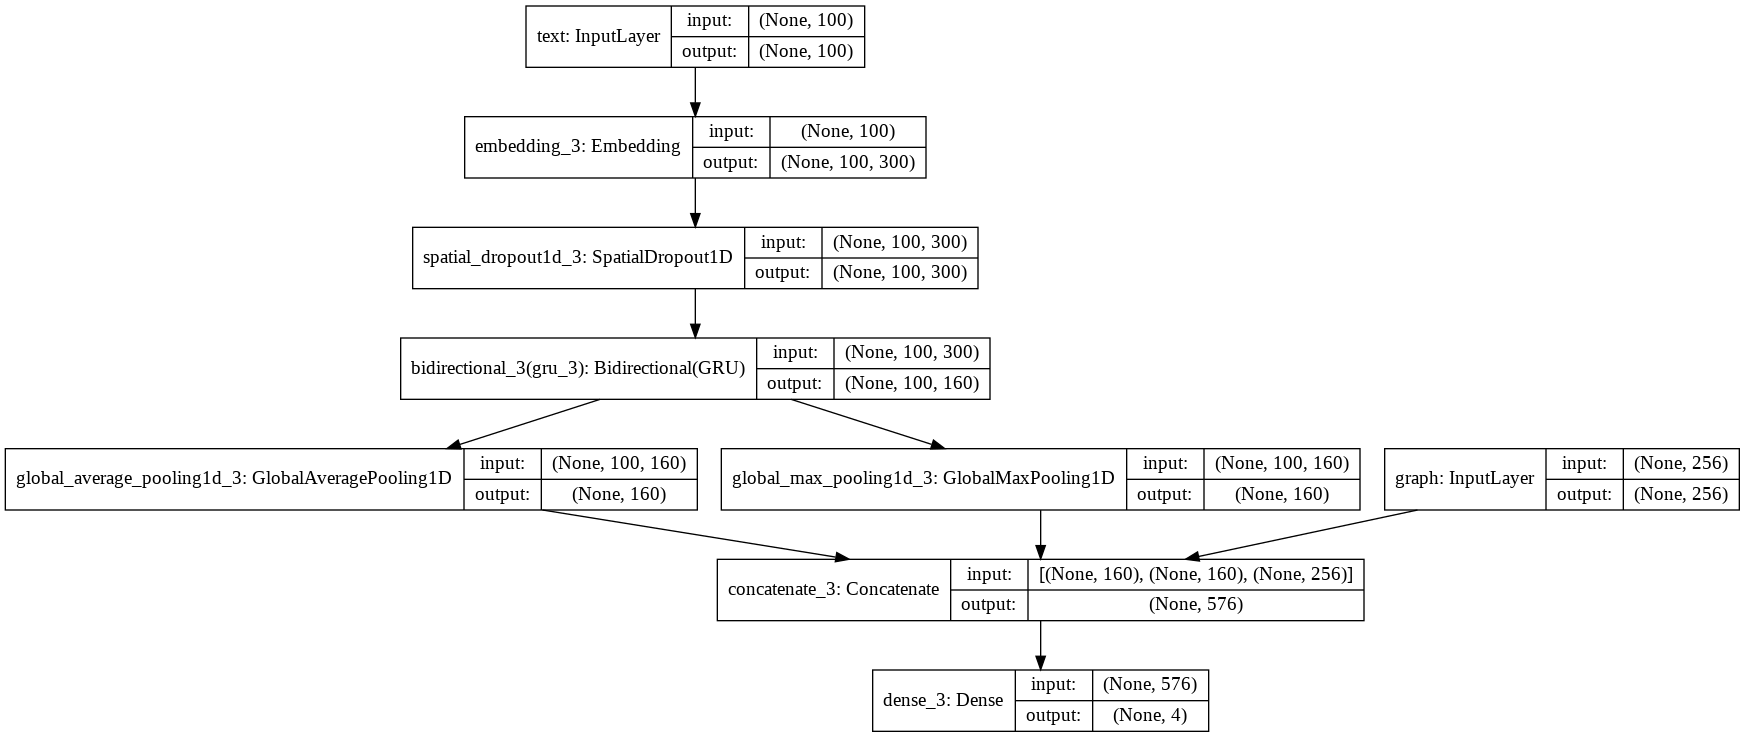

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model = get_model()


batch_size = 32
epochs = 5



# X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit({"text": X_tra, "graph": X_train_graph}, 
                 y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=({"text": X_val, "graph": X_val_graph}, y_val),
                #  callbacks=[RocAuc], 
                 verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1537 samples, validate on 389 samples
Epoch 1/5
 - 18s - loss: 0.5771 - accuracy: 0.7411 - val_loss: 0.5518 - val_accuracy: 0.7500
Epoch 2/5
 - 18s - loss: 0.5176 - accuracy: 0.7552 - val_loss: 0.4692 - val_accuracy: 0.7789
Epoch 3/5
 - 18s - loss: 0.3268 - accuracy: 0.8616 - val_loss: 0.3241 - val_accuracy: 0.8708
Epoch 4/5
 - 18s - loss: 0.0989 - accuracy: 0.9714 - val_loss: 0.3308 - val_accuracy: 0.8766
Epoch 5/5
 - 18s - loss: 0.0334 - accuracy: 0.9912 - val_loss: 0.3617 - val_accuracy: 0.8785


#Kaggle

## Test a grafo

In [ ]:
test.head()

,ID,Tweet,clean_tweet
0,689719109785907200,death toll from #bachakhanuniattack rises to a...,death toll from rises to at least army offici...
1,531300385248800768,"the head of isis, abu bakr al-baghdadi, is sai...",the head of isis abu bakr al baghdadi is said ...
2,652992524504600576,steve jobs was adopted. his biological father ...,steve jobs was adopted his biological father w...
3,509473920060104704,microsoft to buy mojang - report URL $2 billio...,microsoft to buy mojang report url 2 billion...
4,651321040119963648,el chapo puts $100 million bounty on donald tr...,el chapo puts 100 million bounty on donald tru...


In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/test'
fileGraph = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph_test.gpicke'

# add new graph
x_graph_test, _ = createGraph(DIR, fileGraph, test['ID'])

In [ ]:
file_test = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/node_test.word2vec'

x_graph_test = np.array([graphEmbedding(x_graph_test, n) for n in range(len(x_graph_test))])

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 0




Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5709.13it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

Iteración: 1



Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 2943.37it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 5685.54it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 2
Iteración: 3



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 2124.24it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 3273.97it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]



Iteración: 4
Iteración: 5



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3755.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

Iteración: 6



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7776.83it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7075.41it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]

Iteración: 7
Iteración: 8



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1481.77it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2533.67it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]

Iteración: 9
Iteración: 10



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 11


Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3379.32it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

Iteración: 12



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2586.80it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 2979.23it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 13
Iteración: 14



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 3004.52it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]

Iteración: 15
Iteración: 16



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 6673.51it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 6235.46it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 17
Iteración: 18



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3443.40it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

Iteración: 19



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5573.56it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

Iteración: 20



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5351.83it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 21
Iteración: 22



Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 4194.78it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 23


Computing transition probabilities: 100%|██████████| 123/123 [00:00<00:00, 2389.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 24


Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 3963.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 3597.64it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 25
Iteración: 26



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 1829.04it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5069.41it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 27
Iteración: 28



Computing transition probabilities: 100%|██████████| 127/127 [00:00<00:00, 1848.44it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 29


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5471.66it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

Iteración: 30



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6654.10it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 4602.70it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 31
Iteración: 32


Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 5053.38it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 71/71 [00:00<00:00, 3659.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 33
Iteración: 34



Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3493.54it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 35


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4157.30it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

Iteración: 36



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 4815.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 37


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 7228.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 5774.22it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 38
Iteración: 39



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 40


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7592.87it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6051.71it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 41
Iteración: 42



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3767.90it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Iteración: 43


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 44


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8099.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 4187.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 45
Iteración: 46


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3753.42it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 4135.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 47
Iteración: 48



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5443.06it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 49
Iteración: 50



Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 6280.56it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Iteración: 51


Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 3649.91it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 64/64 [00:00<00:00, 3816.80it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 52
Iteración: 53



Computing transition probabilities: 100%|██████████| 42/42 [00:00<00:00, 3945.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 54


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8233.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 2321.14it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 27.21it/s]

Iteración: 55
Iteración: 56



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6340.60it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Iteración: 57


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 58


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

Iteración: 59



Computing transition probabilities: 100%|██████████| 69/69 [00:00<00:00, 3509.75it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 60


Computing transition probabilities: 100%|██████████| 90/90 [00:00<00:00, 2827.09it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 61


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3273.73it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 3745.98it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 62
Iteración: 63



Computing transition probabilities: 100%|██████████| 23/23 [00:00<00:00, 4068.88it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

Iteración: 64



Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 3487.52it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 65


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5409.07it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

Iteración: 66



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

Iteración: 67



Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 4114.73it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 68


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1476.24it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 99/99 [00:00<00:00, 2613.17it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 69
Iteración: 70



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 6329.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 5447.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 71
Iteración: 72



Computing transition probabilities: 100%|██████████| 49/49 [00:00<00:00, 3688.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 73


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8475.79it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 13/13 [00:00<00:00, 6826.84it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 74
Iteración: 75



Computing transition probabilities: 100%|██████████| 28/28 [00:00<00:00, 5338.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

Iteración: 76



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 77



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7901.36it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3622.89it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 78
Iteración: 79



Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 1326.98it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 80
Iteración: 81



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5408.52it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Iteración: 82


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 2632.96it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

Iteración: 83



Computing transition probabilities: 100%|██████████| 47/47 [00:00<00:00, 3562.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 84


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 85


Computing transition probabilities: 100%|██████████| 114/114 [00:00<00:00, 2219.61it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 86


Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3420.57it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

Iteración: 87



Computing transition probabilities: 100%|██████████| 222/222 [00:00<00:00, 1218.67it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]



Iteración: 88



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3187.31it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 22/22 [00:00<00:00, 3535.16it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 89
Iteración: 90



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

Iteración: 91



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 92
Iteración: 93



Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 3487.83it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]

Iteración: 94



Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 4730.70it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

Iteración: 95



Computing transition probabilities: 100%|██████████| 91/91 [00:00<00:00, 2672.82it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 96


Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 3879.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 97


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3103.28it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 3/3 [00:00<00:00, 7006.08it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]

Iteración: 98
Iteración: 99



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6443.96it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 2628.83it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 100
Iteración: 101


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 1254.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3549.23it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 102
Iteración: 103



Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5937.79it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]





Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]

Iteración: 104



Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5934.22it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

Iteración: 105



Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 4163.25it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Iteración: 106



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 107



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4331.47it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 6406.78it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 108
Iteración: 109



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 7178.95it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

Iteración: 110



Computing transition probabilities: 100%|██████████| 124/124 [00:00<00:00, 2177.26it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 111


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 5985.45it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

Iteración: 112



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 5544.35it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 113
Iteración: 114



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

Iteración: 115



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4373.62it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 75/75 [00:00<00:00, 3919.76it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 116
Iteración: 117



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 5579.65it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 61/61 [00:00<00:00, 3771.24it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 118
Iteración: 119



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]

Iteración: 120



Computing transition probabilities: 100%|██████████| 56/56 [00:00<00:00, 3684.06it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 121


Computing transition probabilities: 100%|██████████| 109/109 [00:00<00:00, 2435.86it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 122


Computing transition probabilities: 100%|██████████| 58/58 [00:00<00:00, 4696.69it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 123


Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 2055.46it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Iteración: 124
Iteración: 125


Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 74/74 [00:00<00:00, 3048.64it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 126


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 3125.91it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 4123.58it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 127
Iteración: 128



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 4748.52it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 4614.20it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 129
Iteración: 130



Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6560.19it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Iteración: 131


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3117.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 3205.31it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 132
Iteración: 133



Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 2573.98it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 134


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2537.73it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 135
Iteración: 136



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 137


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 4262.50it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 126/126 [00:00<00:00, 1843.11it/s]

Iteración: 138
Iteración: 139



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 140



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

Iteración: 141



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities:   0%|          | 0/157 [00:00<?, ?it/s]

Iteración: 142
Iteración: 143


Computing transition probabilities: 100%|██████████| 157/157 [00:00<00:00, 1605.18it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 7664.33it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7992.53it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 144
Iteración: 145



Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 4779.00it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Iteración: 146


Computing transition probabilities: 100%|██████████| 99/99 [00:00<00:00, 2712.22it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 147


Computing transition probabilities: 100%|██████████| 36/36 [00:00<00:00, 4327.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 148


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 149


Computing transition probabilities: 100%|██████████| 96/96 [00:00<00:00, 4234.98it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 150


Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 2211.41it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

Iteración: 151



Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 4297.08it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 5283.55it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 152
Iteración: 153



Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 4387.58it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 154
Iteración: 155



Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 7743.33it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 4849.84it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]

Iteración: 156
Iteración: 157



Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 7036.24it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 158
Iteración: 159





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 33/33 [00:00<00:00, 5139.12it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

Iteración: 160



Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 5551.69it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 10/10 [00:00<00:00, 6438.91it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 161
Iteración: 162


Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 4638.43it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Iteración: 163
Iteración: 164


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

Iteración: 165



Computing transition probabilities: 100%|██████████| 45/45 [00:00<00:00, 3798.50it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 166


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 3255.65it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

Iteración: 167



Computing transition probabilities: 100%|██████████| 65/65 [00:00<00:00, 4014.10it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 168


Computing transition probabilities: 100%|██████████| 11/11 [00:00<00:00, 7776.39it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3655.96it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 169
Iteración: 170



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 5986.85it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 171


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 8308.64it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Iteración: 172


Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 6867.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 3881.82it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]

Iteración: 173
Iteración: 174



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 7002.18it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 46/46 [00:00<00:00, 4030.12it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 175
Iteración: 176



Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 3351.49it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 177


Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3487.26it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 26/26 [00:00<00:00, 6754.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 178
Iteración: 179



Computing transition probabilities: 100%|██████████| 9/9 [00:00<00:00, 5568.48it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 180


Computing transition probabilities: 100%|██████████| 30/30 [00:00<00:00, 5345.11it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 181


Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 6572.67it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]

Iteración: 182



Computing transition probabilities: 100%|██████████| 84/84 [00:00<00:00, 3246.46it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 183



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 3460.16it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 184


Computing transition probabilities: 100%|██████████| 5/5 [00:00<00:00, 7142.89it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities:  79%|███████▊  | 158/201 [00:00<00:00, 1574.01it/s]

Iteración: 185
Iteración: 186


Computing transition probabilities: 100%|██████████| 201/201 [00:00<00:00, 1520.76it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 187





Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 107/107 [00:00<00:00, 2642.04it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]



Iteración: 188



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 51/51 [00:00<00:00, 3479.39it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 189


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 5736.89it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 190
Iteración: 191



Computing transition probabilities: 100%|██████████| 8/8 [00:00<00:00, 3135.05it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]






Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 192
Iteración: 193



Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 3735.70it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Iteración: 194


Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 3603.35it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

Iteración: 195



Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3491.22it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Iteración: 196


Computing transition probabilities: 100%|██████████| 24/24 [00:00<00:00, 6170.74it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Iteración: 197


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3638.57it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Iteración: 198



Computing transition probabilities: 100%|██████████| 152/152 [00:00<00:00, 1907.18it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 199


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 2/2 [00:00<00:00, 4969.55it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 3868.39it/s]



Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 200
Iteración: 201



Computing transition probabilities: 100%|██████████| 41/41 [00:00<00:00, 3492.91it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 202


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]




Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 35/35 [00:00<00:00, 4766.10it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]

Iteración: 203
Iteración: 204



Computing transition probabilities: 100%|██████████| 7/7 [00:00<00:00, 8030.67it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 18/18 [00:00<00:00, 6025.82it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 205
Iteración: 206


Computing transition probabilities: 100%|██████████| 6/6 [00:00<00:00, 5451.87it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 12/12 [00:00<00:00, 3154.80it/s]

Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]

Iteración: 207
Iteración: 208



Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 3728.61it/s]


Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]


Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]


Iteración: 209


Computing transition probabilities: 100%|██████████| 17/17 [00:00<00:00, 4596.05it/s]

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

Iteración: 210



Computing transition probabilities: 100%|██████████| 55/55 [00:00<00:00, 3699.45it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]


Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Iteración: 211


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 3361.36it/s]


Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]

Iteración: 212


In [ ]:
asd = model.predict({"text": x_test, "graph": embeddings})
asd = np.argmax(asd, axis=1)

NameError: ignored

In [ ]:
print(asd)

In [ ]:
pred = le.inverse_transform(asd)

In [ ]:
sample = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/sample_submission.csv')

sample['label'] = pred
sample['id'] = test['ID']
sample.to_csv('./drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/sample_node2vec_final.csv', header=True, index=False)